In [12]:
import gymnasium as gym
import torch
from torch.utils.tensorboard import SummaryWriter
import tianshou as ts
from uxsim import *
import pandas as pd
import itertools

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from scipy.optimize import minimize

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import copy

%matplotlib inline

In [ ]:
class TrafficSim(gym.Env):
    def __init__(self):
        """
        traffic scenario: 4 signalized intersections as shown below:
                N1  N2
                |   |
            W1--I1--I2--E1
                |   |
            W2--I3--I4--E2
                |   |
                S1  S2
        Traffic demand is generated from each boundary node to all other boundary nodes.
        action: to determine which direction should have greenlight for every 10 seconds for each intersection. 16 actions.
            action 1: greenlight for I1: direction 0, I2: 0, I3: 0, I4: 0, where direction 0 is E<->W, 1 is N<->S.
            action 2: greenlight for I1: 1, I2: 0, I3: 0, I4: 0
            action 3: greenlight for I1: 0, I2: 1, I3: 0, I4: 0
            action 4: greenlight for I1: 1, I2: 1, I3: 0, I4: 0
            action 5: ...
        state: number of waiting vehicles at each incoming link. 16 dimension.
        reward: negative of difference of total waiting vehicles
        """
        
        #action
        self.n_action = 2**4
        self.action_space = gym.spaces.Discrete(self.n_action) 
        
        #state
        self.n_state = 4*4
        low = np.array([0 for i in range(self.n_state)])
        high = np.array([100 for i in range(self.n_state)])
        self.observation_space = gym.spaces.Box(low=low, high=high)
        
        self.reset()
    
    def reset(self):
        """
        reset the env
        """
        seed = None #whether demand is always random or not
        W = World(
            name="",
            deltan=5,
            tmax=4000,
            print_mode=0, save_mode=0, show_mode=1,
            random_seed=seed,
            duo_update_time=600
        )
        random.seed(seed)

        #network definition
        I1 = W.addNode("I1", 0, 0, signal=[60,60])
        I2 = W.addNode("I2", 1, 0, signal=[60,60])
        I3 = W.addNode("I3", 0, -1, signal=[60,60])
        I4 = W.addNode("I4", 1, -1, signal=[60,60])
        W1 = W.addNode("W1", -1, 0)
        W2 = W.addNode("W2", -1, -1)
        E1 = W.addNode("E1", 2, 0)
        E2 = W.addNode("E2", 2, -1)
        N1 = W.addNode("N1", 0, 1)
        N2 = W.addNode("N2", 1, 1)
        S1 = W.addNode("S1", 0, -2)
        S2 = W.addNode("S2", 1, -2)
        #E <-> W direction: signal group 0
        for n1,n2 in [[W1, I1], [I1, I2], [I2, E1], [W2, I3], [I3, I4], [I4, E2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
        #N <-> S direction: signal group 1
        for n1,n2 in [[N1, I1], [I1, I3], [I3, S1], [N2, I2], [I2, I4], [I4, S2]]:
            W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
            W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

        # random demand definition
        dt = 30
        demand = 0.22
        for n1, n2 in itertools.permutations([W1, W2, E1, E2, N1, N2, S1, S2], 2):
            for t in range(0, 3600, dt):
                W.adddemand(n1, n2, t, t+dt, random.uniform(0, demand))
        
        # store UXsim object for later re-use
        self.W = W
        self.I1 = I1
        self.I2 = I2
        self.I3 = I3
        self.I4 = I4
        self.INLINKS = list(self.I1.inlinks.values()) + list(self.I2.inlinks.values()) + list(self.I3.inlinks.values()) + list(self.I4.inlinks.values())
        
        #initial observation
        observation = np.array([0 for i in range(self.n_state)])
        
        #log
        self.log_state = []
        self.log_reward = []
        
        return observation, None
    
    def comp_state(self):
        """
        compute the current state
        """
        vehicles_per_links = {}
        for l in self.INLINKS:
            vehicles_per_links[l] = l.num_vehicles_queue #l.num_vehicles_queue: the number of vehicles in queue in link l
        return list(vehicles_per_links.values())
    
    def comp_n_veh_queue(self):
        return sum(self.comp_state())
    
    def step(self, action_index):
        """
        proceed env by 1 step = `operation_timestep_width` seconds
        """
        operation_timestep_width = 10
        
        n_queue_veh_old = self.comp_n_veh_queue()
        
        #change signal by action
        #decode action
        binstr = f"{action_index:04b}"
        i1, i2, i3, i4 = int(binstr[3]), int(binstr[2]), int(binstr[1]), int(binstr[0])
        self.I1.signal_phase = i1
        self.I1.signal_t = 0
        self.I2.signal_phase = i2
        self.I2.signal_t = 0
        self.I3.signal_phase = i3
        self.I3.signal_t = 0
        self.I4.signal_phase = i4
        self.I4.signal_t = 0
        
        #traffic dynamics. execute simulation for `operation_timestep_width` seconds
        if self.W.check_simulation_ongoing():
            self.W.exec_simulation(duration_t=operation_timestep_width)
        
        #observe state
        observation = np.array(self.comp_state())
        
        #compute reward
        n_queue_veh = self.comp_n_veh_queue()
        reward = -(n_queue_veh-n_queue_veh_old)
        
        #check termination
        done = False
        if self.W.check_simulation_ongoing() == False:
            done = True
        
        #log
        self.log_state.append(observation)
        self.log_reward.append(reward)
        
        return observation, reward, done, {}, None

In [13]:
# world definition
seed = None
W = World(
    name="",
    deltan=5,
    tmax=3600,
    print_mode=1, save_mode=0, show_mode=1,
    random_seed=seed,
    duo_update_time=600
)
random.seed(seed)

# network definition
"""
    N1  N2
    |   |
W1--I1--I2--E1
    |   |
W2--I3--I4--E2
    |   |
    S1  S2
"""

I1 = W.addNode("I1", 0, 0, signal=[60,60])
I2 = W.addNode("I2", 1, 0, signal=[60,60])
I3 = W.addNode("I3", 0, -1, signal=[60,60])
I4 = W.addNode("I4", 1, -1, signal=[60,60])
W1 = W.addNode("W1", -1, 0)
W2 = W.addNode("W2", -1, -1)
E1 = W.addNode("E1", 2, 0)
E2 = W.addNode("E2", 2, -1)
N1 = W.addNode("N1", 0, 1)
N2 = W.addNode("N2", 1, 1)
S1 = W.addNode("S1", 0, -2)
S2 = W.addNode("S2", 1, -2)
#E <-> W direction: signal group 0
for n1,n2 in [[W1, I1], [I1, I2], [I2, E1], [W2, I3], [I3, I4], [I4, E2]]:
    W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
    W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=0)
#N <-> S direction: signal group 1
for n1,n2 in [[N1, I1], [I1, I3], [I3, S1], [N2, I2], [I2, I4], [I4, S2]]:
    W.addLink(n1.name+n2.name, n1, n2, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)
    W.addLink(n2.name+n1.name, n2, n1, length=500, free_flow_speed=10, jam_density=0.2, signal_group=1)

# random demand definition
dt = 30
demand = 0.22
for n1, n2 in itertools.permutations([W1, W2, E1, E2, N1, N2, S1, S2], 2):
    for t in range(0, 3600, dt):
        W.adddemand(n1, n2, t, t+dt, random.uniform(0, demand))x

    3595 s|     1600 vehs|   0.0 m/s|   353.80 s
 simulation finished
results:
 average speed:	 1.4 m/s
 number of completed trips:	 2185 / 8300
 average travel time of trips:	 426.6 s
 average delay of trips:	 273.6 s
 delay ratio:			 0.641


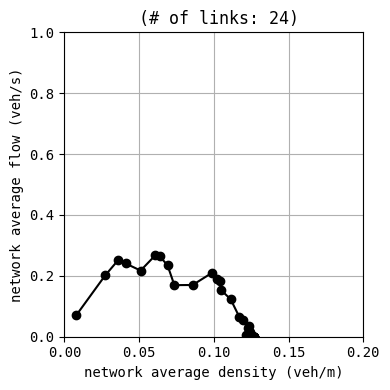

 drawing trajectories in consecutive links...


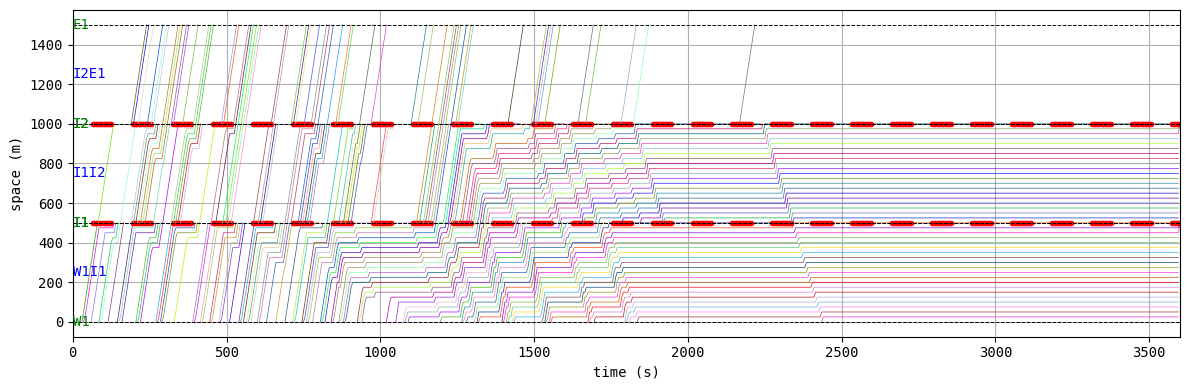

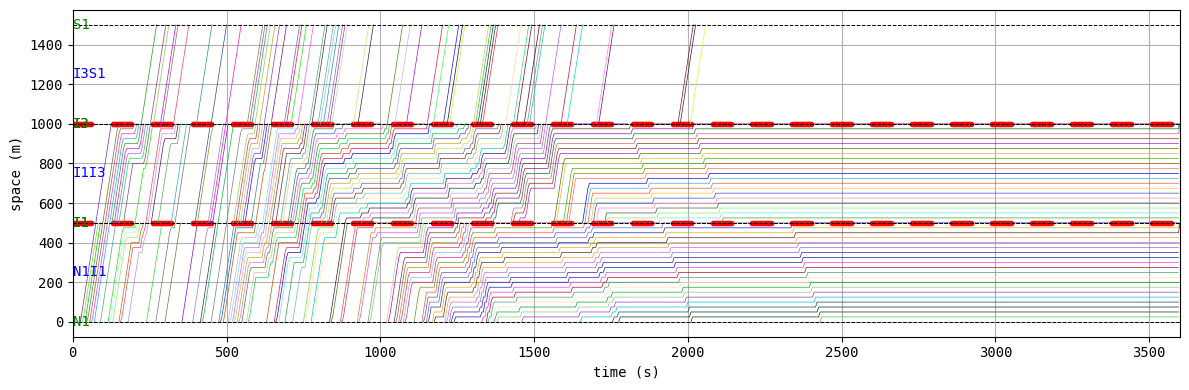

 generating animation...


  0%|          | 0/360 [00:00<?, ?it/s]

In [15]:
# simulation
W.exec_simulation()

# resutls
W.analyzer.print_simple_stats()
W.analyzer.macroscopic_fundamental_diagram()
W.analyzer.time_space_diagram_traj_links([["W1I1", "I1I2", "I2E1"], ["N1I1", "I1I3", "I3S1"]])
W.analyzer.network_fancy(network_font_size=1, figsize=(6,6))

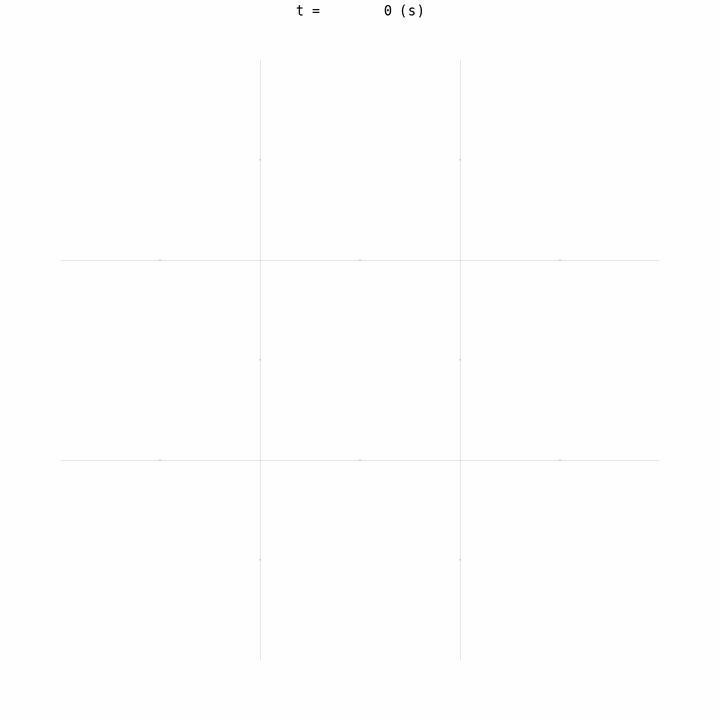

In [16]:
from IPython.display import display, Image
with open("out/anim_network_fancy.gif", "rb") as f:
    display(Image(data=f.read(), format='png'))

In [2]:
task = 'CartPole-v1'
lr, epoch, batch_size = 1e-3, 10, 64
train_num, test_num = 10, 100
gamma, n_step, target_freq = 0.9, 3, 320
buffer_size = 20000
eps_train, eps_test = 0.1, 0.05
step_per_epoch, step_per_collect = 10000, 10

In [3]:
logger = ts.utils.TensorboardLogger(SummaryWriter('log/dqn'))
# For other loggers, see https://tianshou.readthedocs.io/en/master/01_tutorials/05_logger.html

In [4]:
# You can also try SubprocVectorEnv, which will use parallelization
train_envs = ts.env.DummyVectorEnv([lambda: gym.make(task) for _ in range(train_num)])
test_envs = ts.env.DummyVectorEnv([lambda: gym.make(task) for _ in range(test_num)])

In [5]:
from tianshou.utils.net.common import Net

# Note: You can easily define other networks.
# See https://tianshou.readthedocs.io/en/master/01_tutorials/00_dqn.html#build-the-network
env = gym.make(task, render_mode="human")
state_shape = env.observation_space.shape or env.observation_space.n
action_shape = env.action_space.shape or env.action_space.n
net = Net(state_shape=state_shape, action_shape=action_shape, hidden_sizes=[128, 128, 128])
optim = torch.optim.Adam(net.parameters(), lr=lr)

In [6]:
policy = ts.policy.DQNPolicy(
    model=net,
    optim=optim,
    discount_factor=gamma, 
    action_space=env.action_space,
    estimation_step=n_step,
    target_update_freq=target_freq
)
train_collector = ts.data.Collector(policy, train_envs, ts.data.VectorReplayBuffer(buffer_size, train_num), exploration_noise=True)
test_collector = ts.data.Collector(policy, test_envs, exploration_noise=True)  # because DQN uses epsilon-greedy method

In [7]:
result = ts.trainer.OffpolicyTrainer(
    policy=policy,
    train_collector=train_collector,
    test_collector=test_collector,
    max_epoch=epoch,
    step_per_epoch=step_per_epoch,
    step_per_collect=step_per_collect,
    episode_per_test=test_num,
    batch_size=batch_size,
    update_per_step=1 / step_per_collect,
    train_fn=lambda epoch, env_step: policy.set_eps(eps_train),
    test_fn=lambda epoch, env_step: policy.set_eps(eps_test),
    stop_fn=lambda mean_rewards: mean_rewards >= env.spec.reward_threshold,
    logger=logger,
).run()
print(f"Finished training in {result.timing.total_time} seconds")

Epoch #1: 10001it [00:09, 1075.03it/s, env_step=10000, gradient_step=1000, len=193, n/ep=0, n/st=10, rew=193.00]                           


Epoch #1: test_reward: 207.510000 ± 29.486775, best_reward: 207.510000 ± 29.486775 in #1


Epoch #2: 10001it [00:12, 814.13it/s, env_step=20000, gradient_step=2000, len=232, n/ep=0, n/st=10, rew=232.00]                           


Epoch #2: test_reward: 350.980000 ± 75.211699, best_reward: 350.980000 ± 75.211699 in #2


Epoch #3: 10001it [00:10, 938.22it/s, env_step=30000, gradient_step=3000, len=273, n/ep=0, n/st=10, rew=273.00]                            


Epoch #3: test_reward: 254.730000 ± 24.105126, best_reward: 350.980000 ± 75.211699 in #2


Epoch #4: 10001it [00:08, 1132.21it/s, env_step=40000, gradient_step=4000, len=256, n/ep=0, n/st=10, rew=256.00]                           


Epoch #4: test_reward: 256.900000 ± 24.863829, best_reward: 350.980000 ± 75.211699 in #2


Epoch #5: 10001it [00:08, 1184.92it/s, env_step=50000, gradient_step=5000, len=245, n/ep=0, n/st=10, rew=245.00]                           


Epoch #5: test_reward: 245.920000 ± 19.266904, best_reward: 350.980000 ± 75.211699 in #2


Epoch #6: 10001it [00:08, 1141.69it/s, env_step=60000, gradient_step=6000, len=237, n/ep=0, n/st=10, rew=237.00]                           


Epoch #6: test_reward: 270.570000 ± 24.397645, best_reward: 350.980000 ± 75.211699 in #2


Epoch #7: 10001it [00:08, 1128.99it/s, env_step=70000, gradient_step=7000, len=213, n/ep=0, n/st=10, rew=213.00]                          


Epoch #7: test_reward: 226.330000 ± 10.177480, best_reward: 350.980000 ± 75.211699 in #2


Epoch #8: 10001it [00:08, 1122.28it/s, env_step=80000, gradient_step=8000, len=239, n/ep=0, n/st=10, rew=239.00]                           


Epoch #8: test_reward: 213.930000 ± 8.835446, best_reward: 350.980000 ± 75.211699 in #2


Epoch #9: 10001it [00:09, 1046.32it/s, env_step=90000, gradient_step=9000, len=343, n/ep=0, n/st=10, rew=343.00]                           


Epoch #9: test_reward: 468.430000 ± 48.172659, best_reward: 468.430000 ± 48.172659 in #9


Epoch #10: 10001it [00:21, 457.50it/s, env_step=100000, gradient_step=10000, len=191, n/ep=0, n/st=10, rew=191.00]                           


Epoch #10: test_reward: 176.160000 ± 9.569451, best_reward: 468.430000 ± 48.172659 in #9
Finished training in 127.54945468902588 seconds


In [8]:
torch.save(policy.state_dict(), 'dqn.pth')
policy.load_state_dict(torch.load('dqn.pth'))

<All keys matched successfully>

In [10]:
policy.eval()
policy.set_eps(eps_test)
collector = ts.data.Collector(policy, env, exploration_noise=True)
collector.collect(n_episode=1, render=1 / 35)

c:\Users\lalit\source\landru\venv\Lib\site-packages\tianshou\data\collector.py:101: UserWarning: Single environment detected, wrap to DummyVectorEnv.
  warnings.warn("Single environment detected, wrap to DummyVectorEnv.")


CollectStats(n_collected_episodes=1, n_collected_steps=180, collect_time=9.335633993148804, collect_speed=19.280961542847294, returns=array([180.]), returns_stat=SequenceSummaryStats(mean=180.0, std=0.0, max=180.0, min=180.0), lens=array([180]), lens_stat=SequenceSummaryStats(mean=180.0, std=0.0, max=180.0, min=180.0))